# AI2023_C6_Project: Distribusi Strategis Tangki Air
Ketua: 
- Hugo Alfedo Putra (225150201111013)

Anggota:
- Farrel Rakha Dzakwan (NIM)
- Kartika Madania (NIM)
- Nafakhatul Fadhliyah (NIM)
- Rayhan Egar Sadtya N. (225150201111014)

## Project Description

- Detailed proposal: <a href="https://drive.google.com/file/d/17-KTcC_7lHK3ccReEwo3SYMl73sKyIs8/view?usp=sharing">Click Here (UB Account)</a>
- Case example: <a href="https://drive.google.com/file/d/1cw2pzo-zphH3vdL3rC1ZDHoAic22058L/view?usp=sharing">Click Here (UB Account)</a>

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import heapq
import networkx as nx

## Class: Node
Node mereperesentasikan sebuah desa, memiliki atribut seperti:
- (str) name 
- (int[]) coordinate
- (int) population
- (object[]) neighbors

In [2]:
class Node:
    
    # initialization function
    def __init__(self, name, coordinate_x, coordinate_y, population):
        self.name = name
        self.coordinate = np.array([coordinate_x, coordinate_y])
        self.population = population
        self.neighbors = []
        self.c_range = 100 # default value
    
    # This is to take care when comparing (k_1, Node_1) < (k_2, Node_2) where k_1 = k_2. 
    # Such case where k_1 = k_2 would trigger heapq to compare the Node object. Comparing 
    # such object would raise an error because we did not and we can not put a comparator 
    # in the Node class. Therefore, this function below is to say that if such case happens, 
    # *always* prioritise the more populous node.
    def __lt__(self, other):
        return self.population < other.population

    # Coordinates are more unique than names
    def __hash__(self):
        return hash(self.coordinate[0])

    def get_choice_range(self):
        return self.c_range

    # Establishes bi-directional path
    def add_neighbor(self, neighbor):
        # The if-condition below guarantees no recursive connections
        # i.e. a node can't be neighbors with itself
        if self.coordinate[0] != neighbor.coordinate[0]:
            sld = np.sqrt(np.power(neighbor.coordinate[0] - self.coordinate[0], 2) + np.power(neighbor.coordinate[1] - self.coordinate[1] ,2))
            cost = random.choice([i for i in range(self.get_choice_range())])
            self.neighbors.append([neighbor, sld, cost])
            neighbor.neighbors.append([self, sld, cost])
    
    # Get neighbors
    def get_neighbor(self):
        its_neighbors = []
        for i in range(len(self.neighbors)):
            its_neighbors.append(self.neighbors[i][0].name)
        return its_neighbors
    
    def get_cost(self):
        its_costs = []
        for i in range(len(self.neighbors)):
            its_costs.append(self.neighbors[i][2])
        return its_costs
    
    def get_sld(self):
        its_slds = []
        for i in range(len(self.neighbors)):
            its_slds.append(self.neighbors[i][1])
        return its_slds

    # Print node information
    def print_info(self):
        print(f"Name: {self.name}")
        print(f"Coordinate [X, Y]: {self.coordinate}")
        print(f"Population: {self.population}")
        print(f"Neighbors: {self.get_neighbor()}")
        print(f"Cost: {self.get_cost()}")
        print(f"SLD: {self.get_sld()}")

    # Quick debug purposes
    def minimal_print(self):
        print(f"ID: {self.name} \t -> {self.get_neighbor()}")

## Class: Environment

In [3]:
class Environment:
    
    # Initialization function
    def __init__(self, *args):

        # Random generation needs name, area_size, node_number
        if len(args) > 1 and isinstance(args[0], str):
            self.name = args[0]
            self.node_number = args[2]
            self.empty_node_avail = args[2] # kind of redundant (read more below)
            self.area_size = args[1]
            self.area = [[None for _ in range(args[1])] for _ in range(args[1])]

            self.node_list = [] # Used to store generated nodes
            # Note: making an array filled with None and then *appending* instead of *updating*
            # the values doesn't make any sense because you'd have Nones in front of everything else
            
            self.node_score = [None for _ in range(args[2])] # Used to store f(n) values for generated nodes

        # Nodes generated from data will only need Node
        if len(args) == 1 and isinstance(args[0], list):
            self.nodes = args[0]
            self.node_number = len(args[0])
            self.node_list = [] 
            self.node_score = [None for _ in range(len(args[0]))]
    
    # Add node
    def add_node(self, node):
        self.area[node.coordinate[0]][node.coordinate[1]] = node
        self.node_list.append(node)
        self.empty_node_avail -= 1 # you have a while loop using "remaining" as a decreasing variable, I don't think this is useful
    
    def add_node_from_data(self, node):
        self.node_list.append(node)

    # Generate test case environment
    def test_case(self):
        O_node = Node("O", 0, 0, 0)
        A_node = Node("A", -3, 3, 300)
        B_node = Node("B", 1, 6, 100)
        C_node = Node("C", 5, 5, 150)
        D_node = Node("D", 2, 3, 400)
        E_node = Node("E", 5, 3, 250)
        F_node = Node("F", 4, 0, 75)
        self.add_node(O_node)
        self.add_node(A_node)
        self.add_node(B_node)
        self.add_node(C_node)
        self.add_node(D_node)
        self.add_node(E_node)
        self.add_node(F_node)
        O_node.add_neighbor(D_node)
        O_node.add_neighbor(F_node)
        A_node.add_neighbor(B_node)
        A_node.add_neighbor(D_node)
        B_node.add_neighbor(A_node)
        B_node.add_neighbor(D_node)
        B_node.add_neighbor(C_node)
        C_node.add_neighbor(B_node)
        C_node.add_neighbor(E_node)
        D_node.add_neighbor(E_node)
        D_node.add_neighbor(F_node)
        self.node_number = 7

    # Populate area 
    def populate_area(self):
        # Makes sure the origin node is registered in node_list and area after creation
        new_node = Node("origin", 0, 0, 0)
        self.add_node(new_node)

        remaining = self.node_number
        naming_counter = 0

        # Generate randomly-placed nodes
        while(remaining > 0):

            # Randomize index
            x_loc = np.random.randint(1, self.area_size)
            y_loc = np.random.randint(1, self.area_size)

            # If index empty, initialize node
            if (self.area[x_loc][y_loc] is None):
                # Creates data for new_node
                node_name = str(self.name) + "node" + str(naming_counter) 
                naming_counter += 1
                node_population = np.random.randint(50, 1000)

                # Creates the new_node
                new_node = Node(node_name, x_loc, y_loc, node_population)

                # Adds the node using a function *you* have created before
                self.add_node(new_node)

                remaining -= 1

        # Generate randomly-put edges (neighbors) between nodes
        # Constraint: 
        #   1. Guaranteed edge from "origin" to at least one node
        #   2. Every node is reachable

        # choice is a list containing all possible integers from 0 to self.node_number
        choice = [i for i in range(self.node_number)]

        for i in range(len(self.node_list)-1):
            # Makes sure there is a path from origin to the last node where
            # it visits every other nodes on the way (satisfies all constraints)
            self.node_list[i].add_neighbor(self.node_list[i+1])

            # Connects one node with random neighbors if it passes a certain
            # threshold (chance > k)
            chance = np.random.random()
            if chance > 0.69: # change this if you want
                self.node_list[i].add_neighbor(self.node_list[random.choice(choice)])

    def populate_from_data(self):
        G = nx.Graph() # this uses netowrkx

        # Pick a place with the heighest population count as the origin
        max_pop = 0; idx = 0
        for i in range(len(self.nodes)):
            # Finds the place with the highest population count and gets its index
            if self.nodes[i].population > max_pop:
                max_pop = self.nodes[i].population
                idx = i
        # Commits it
        self.add_node_from_data(self.nodes[idx])
        self.nodes[idx].population = 0 # origin node is already served by default
        G.add_node(self.nodes[idx].name)

        # Add the rest of the nodes
        for i in range(len(self.nodes)):
            if i != idx:
                self.add_node_from_data(self.nodes[i])
                G.add_node(self.nodes[i].name)
            else: continue

        # Add random neighbors to each other 
        # Generate randomly-put edges (neighbors) between nodes
        # Constraint: 
        #   1. Guaranteed edge from "origin" to at least one node
        #   2. Every node is reachable

        # choice is a list containing all possible integers from 0 to self.node_number
        choice = [i for i in range(len(self.nodes))]

        for i in range(len(self.nodes)-1):
            # Makes sure there is a path from origin to the last node where
            # it visits every other nodes on the way (satisfies all constraints)
            self.nodes[i].add_neighbor(self.nodes[i+1])
            G.add_edge(self.nodes[i].name, self.nodes[i+1].name)

            # Connects one node with random neighbors if it passes a certain
            # threshold (chance > k)
            chance = np.random.random()
            if chance > 0.69: # change this if you want
                neighbor = self.nodes[random.choice(choice)]
                self.nodes[i].add_neighbor(neighbor)
                G.add_edge(self.nodes[i].name, neighbor.name)
        
        # Visualize the graph
        pos = nx.spring_layout(G)  # you can change the layout algorithm as needed
        labels = {i: i for i in G.nodes}
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, font_size=8, font_color='black', node_color=[(0.831,0.831,0.831,1)])
        plt.show()

### Environment Test Case

In [4]:
env = Environment("test", 16, 16)
env.test_case()
for i in range(env.node_number):
    env.node_list[i].minimal_print()

ID: O 	 -> ['D', 'F']
ID: A 	 -> ['B', 'D', 'B']
ID: B 	 -> ['A', 'A', 'D', 'C', 'C']
ID: C 	 -> ['B', 'B']
ID: D 	 -> ['O', 'A', 'B', 'E', 'F']
ID: E 	 -> ['D']
ID: F 	 -> ['O', 'D']


### Referensi Geolokasi Database

Teks di bawah ini sekadar mencontohkan cara kerja kelompok kami:

Didapatkan sebuah batasan berupa koordinat-koordinat dari website https://boundingbox.klokantech.com sebagai berikut:
- batasan Barat: `112.471417`
- batasan Selatan: `-8.048836`
- batasan Timur: `112.745595`
- batasan Utara: `-7.80712`

dengan visualisasi:
<br>
<img src="https://raw.githubusercontent.com/rayhanegar/AI2023_C6/main/visualisasi_1.png" width="800">

dan juga database `ref_db.csv` yang akan digunakan untuk menentukan desa-desa mana saja yang berada di dalam batasan-batasan tersebut.


## Tahapan Kerja

1. Deklarasi batasan

In [5]:
batasan = [102.197763,-1.929685,102.395665,-1.791279]
# dengan urutan barat, selatan, timur, utara

2. Mengambil data dari .csv untuk melakukan referensi geolokasi

In [6]:
url = "https://raw.githubusercontent.com/rayhanegar/AI2023_C6/main/ref_db.csv"
ref_db = pd.read_csv(url)
ref_db.head()

,name,lat,lng,pop
0,LATIUNG,2.357417,96.452420,779
1,LABUHAN BAJAU,2.391348,96.479117,88
2,SUAK LAMATAN,2.353943,96.364809,2205
3,ANA AO,2.439100,96.450882,1890
4,LATALING,2.458705,96.455400,1577


3. Membuat fungsi untuk mencari batasan desa

In [7]:
def cari_desa(batasan):
    kumpulan_desa = []
    for i in range(len(ref_db)):
        if ref_db['lat'][i] >= batasan[1] and ref_db['lat'][i] <= batasan[3] and ref_db['lng'][i] >= batasan[0] and ref_db['lng'][i] <= batasan[2] and ref_db['lat'][i] != 0 and ref_db['lng'][i] != 0:
            new_node = Node(ref_db['name'][i],ref_db['lat'][i],ref_db['lng'][i],ref_db['pop'][i])
            kumpulan_desa.append(new_node)
        else: continue
    return kumpulan_desa

4. Melakukan generasi environment

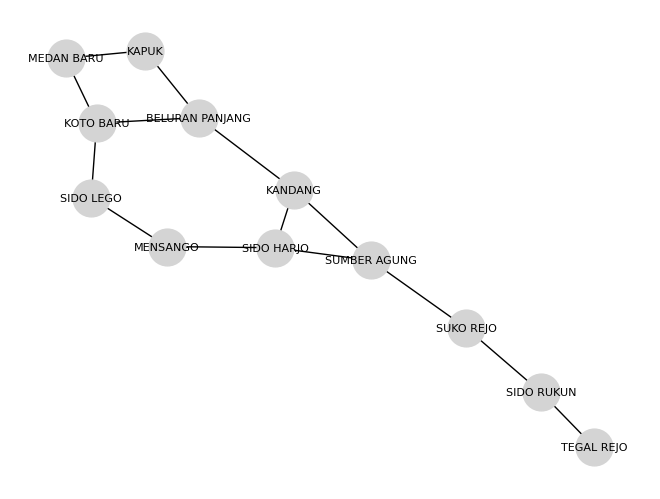

In [8]:
env_on_data = Environment(cari_desa(batasan))
env_on_data.populate_from_data()
# NEVER print on cells where you declare or instantiate a class; it will double up

In [9]:
for i in range(env_on_data.node_number):
    env_on_data.node_list[i].minimal_print()
print("Node origin:")
env_on_data.node_list[0].minimal_print()

ID: SUMBER AGUNG 	 -> ['SIDO HARJO', 'SUKO REJO', 'KANDANG']
ID: KANDANG 	 -> ['BELURAN PANJANG', 'SIDO HARJO', 'SUMBER AGUNG']
ID: BELURAN PANJANG 	 -> ['KANDANG', 'KAPUK', 'KOTO BARU']
ID: KAPUK 	 -> ['BELURAN PANJANG', 'MEDAN BARU']
ID: MEDAN BARU 	 -> ['KAPUK', 'KOTO BARU']
ID: KOTO BARU 	 -> ['BELURAN PANJANG', 'MEDAN BARU', 'SIDO LEGO']
ID: SIDO LEGO 	 -> ['KOTO BARU', 'MENSANGO', 'MENSANGO']
ID: MENSANGO 	 -> ['SIDO LEGO', 'SIDO HARJO', 'SIDO LEGO']
ID: SIDO HARJO 	 -> ['MENSANGO', 'SUMBER AGUNG', 'KANDANG']
ID: SUKO REJO 	 -> ['SUMBER AGUNG', 'SIDO RUKUN']
ID: SIDO RUKUN 	 -> ['SUKO REJO', 'TEGAL REJO']
ID: TEGAL REJO 	 -> ['SIDO RUKUN']
Node origin:
ID: SUMBER AGUNG 	 -> ['SIDO HARJO', 'SUKO REJO', 'KANDANG']


## Environment Evaluation

A* Search, expand minimum $f(n) = g(n) + h(n)$ node first.

$$ g(n) = \frac{cost(root, n)}{n} + \frac{\sum _{i = 0}^n cost(i, n)}{n-1} $$

$$ h(n) = \frac{\sum _{i=0}^{n-1} h_{SLD}(i)}{n-1} + \frac{\sum _{i = 0}^{n-1}\text{population}(h) * d_{SLD}(i, k)}{\text{population}(n)} $$

### Fungsi $g(n)$

In [10]:
def find_index(array, target_node):
    try:
        index = array.index(target_node)
        return index
    except ValueError:
        return None

def find_cost(graph, start_node):
    distances = {node: float('infinity') for node in graph}
    distances[start_node] = 0
    previous_nodes = {node: None for node in graph}

    priority_queue = [(0, start_node)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        for properties in graph[find_index(graph, current_node)].neighbors:
            # neighbor = properties[0]
            # weight = properties[2]
            distance = current_distance + properties[2]
            if distance < distances[properties[0]]:
                distances[properties[0]] = distance
                previous_nodes[properties[0]] = current_node
                heapq.heappush(priority_queue, (distance, properties[0]))

    return [distances, previous_nodes]

def gn(environment):
    iter = environment.node_number
    graph = environment.node_list
    origin = graph[0] # Node at index 0 is always the origin node
    gn_values = []

    # Discovers the graph from the origin
    o_dist, o_prev = find_cost(graph, origin)

    min = float('inf'); idx = 0
    for i in range(1, iter): # We don't need to do calculations on the origin node
        # Define current node
        current_node = graph[i]

        # Find the first term
        term_1 = o_dist[current_node]
        term_1 /= iter

        # Find the second term
        term_2 = 0
        dist, prev = find_cost(graph, current_node)
        for j in range(1, iter):
            if i != j and dist[graph[j]] < float('inf'): term_2 += dist[graph[j]]
            else: continue 
        term_2 /= (iter - 1)
        
        # Add them together
        gn_term = term_1 + term_2
        gn_values.append(gn_term)

        # Find minimum
        if gn_term < min:
            min = gn_term
            idx = i

    return gn_values

### Fungsi $h(n)$

In [11]:
def hn(environment):
    iter = environment.node_number
    graph = environment.node_list
    origin = graph[0] # Node at index 0 is always the origin node
    hn_values = []

    # Find the total population
    pop_sum = []
    for i in range(0, iter):
        pop_sum.append(graph[i].population)
    
    min = float('inf'); idx = 0
    for i in range(1, iter):
        term_1 = 0
        term_2 = 0
        for j in range(1, iter):
            if i != j: 
                sld = np.sqrt((graph[j].coordinate[0] - graph[i].coordinate[0]) ** 2 + (graph[j].coordinate[1] - graph[i].coordinate[1]) ** 2)
                # Calculating first term
                term_1 += sld
                # Calculating second term because second term needs the result from the first term
                term_2 += graph[j].population * sld
            else: continue
        term_1 /= (iter - 1)
        term_2 /= pop_sum[i]
        
        hn_term = term_1 + term_2
        hn_values.append(hn_term)

        # Find minimum
        if hn_term < min:
            min = hn_term
            idx = i
    
    return hn_values

### Mencari $f(n)$ minimum

In [12]:
def fn(environment):
    fn_values = []
    gn_values = gn(environment)
    hn_values = hn(environment)

    fn_values.append(float('inf'))

    min = float('inf'); idx = 0
    for i in range(len(gn_values)):
        fn = gn_values[i] + hn_values[i]
        fn_values.append(fn)
        if fn < min:
            min = fn
            idx = i

    gn_values.insert(0,float('inf'))
    hn_values.insert(0,float('inf'))
    print(gn_values)
    print(hn_values)

    return [min, idx], fn_values

### Eksekusi

In [13]:
min, vals = fn(env_on_data)
print(vals)
print(f'Penempatan truk tangki air di {env_on_data.node_list[min[1]].name} paling efisien dengan nilai f(n) = {min[0]}')

[inf, 92.84848484848486, 92.50757575757576, 140.72727272727275, 155.29545454545453, 102.51515151515152, 124.03030303030303, 137.04545454545456, 131.62121212121212, 116.28030303030303, 127.07575757575758, 186.57575757575756]
[inf, 1.232401441670555, 18.66334764032816, 0.5075465602645894, 0.6721065781857911, 0.1467331495761176, 0.44306444458313954, 23.543511592586352, 1.0364046568843832, 1.9787548112357076, 16.853113453258896, 3.175348749389034]
[inf, 94.08088629015542, 111.17092339790392, 141.23481928753733, 155.96756112364034, 102.66188466472764, 124.47336747488617, 160.58896613804092, 132.6576167780965, 118.25905784153873, 143.92887102901648, 189.7511063251466]
Penempatan truk tangki air di SUMBER AGUNG paling efisien dengan nilai f(n) = 94.08088629015542
